# "The Crank-Nicolson method implemented from scratch in Python"
> "In this article we implement the well-known finite difference method Crank-Nicolson in Python."
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, numpy, numerical analysis, partial differential equations]

# The Crank-Nicolson Method

The [Crank-Nicolson method](http://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method) is a well-known finite difference method for the
numerical integration of the heat equation and closely related partial differential equations.

We often resort to a Crank-Nicolson (CN) scheme when we integrate numerically reaction-diffusion systems in one space dimension

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} + f(u),$$

$$\frac{\partial u}{\partial x}\Bigg|_{x = 0, L} = 0,$$

where $u$ is our concentration variable, $x$ is the space variable, $D$ is the diffusion coefficient of $u$, $f$ is the reaction term,
and $L$ is the length of our one-dimensional space domain.

Note that we use [Neumann boundary conditions](http://en.wikipedia.org/wiki/Neumann_boundary_condition) and specify that the solution
$u$ has zero space slope at the boundaries, effectively prohibiting entrance or exit of material at the boundaries (no-flux boundary conditions).

## Finite Difference Methods

Many fantastic textbooks and tutorials have been written about finite difference methods, for instance a free textbook by
[Lloyd Trefethen](http://people.maths.ox.ac.uk/trefethen/pdetext.html).

Here we describe a few basic aspects of finite difference methods.

The above reaction-diffusion equation describes the time evolution of variable $u(x,t)$ in one space dimension ($u$ is a line concentration).
If we knew an analytic expression for $u(x,t)$ then we could plot $u$ in a two-dimensional coordinate system with axes $t$ and $x$.

To approximate $u(x,t)$ numerically we discretize this two-dimensional coordinate system resulting, in the simplest case, in a
two-dimensional [regular grid](http://en.wikipedia.org/wiki/Regular_grid).
This picture is employed commonly when constructing finite differences methods, see for instance 
[Figure 3.2.1 of Trefethen](http://people.maths.ox.ac.uk/trefethen/3all.pdf).

Let us discretize both time and space as follows:

$$t_n = n \Delta t,~ n = 0, \ldots, N-1,$$

$$x_j = j \Delta x,~ j = 0, \ldots, J-1,$$

where $N$ and $J$ are the number of discrete time and space points in our grid respectively.
$\Delta t$ and $\Delta x$ are the time step and space step respectively and defined as follows:

$$\Delta t = T / N,$$

$$\Delta x = L / J,$$

where $T$ is the point in time up to which we will integrate $u$ numerically.

Our ultimate goal is to construct a numerical method that allows us to approximate the unknonwn analytic solution $u(x,t)$
reasonably well in these discrete grid points.

That is we want construct a method that computes values $U(j \Delta x, n \Delta t)$ (note: capital $U$) so that

$$U(j \Delta x, n \Delta t) \approx u(j \Delta x, n \Delta t)$$

As a shorthand we will write $U_j^n = U(j \Delta x, n \Delta t)$ and $(j,n)$ to refer to grid point $(j \Delta x, n \Delta t)$.

## The Crank-Nicolson Stencil

Based on the two-dimensional grid we construct we then approximate the operators of our reaction-diffusion system.

For instance, to approximate the time derivative on the left-hand side in grid point $(j,n)$ we use the values of $U$ in two specific grid points:

$$\frac{\partial u}{\partial t}\Bigg|_{x = j \Delta x, t = n \Delta t} \approx \frac{U_j^{n+1} - U_j^n}{\Delta t}.$$

We can think of this scheme as a stencil that we superimpose on our $(x,t)$-grid and this particular stencil is
commonly referred to as [forward difference](http://en.wikipedia.org/wiki/Finite_difference#Forward.2C_backward.2C_and_central_differences).

The spatial part of the [Crank-Nicolson stencil](http://journals.cambridge.org/abstract_S0305004100023197)
(or see [Table 3.2.2 of Trefethen](http://people.maths.ox.ac.uk/trefethen/3all.pdf))
for the heat equation ($u_t = u_{xx}$) approximates the 
[Laplace operator](http://en.wikipedia.org/wiki/Laplace_operator) of our equation and takes the following form

$$\frac{\partial^2 u}{\partial x^2}\Bigg|_{x = j \Delta x, t = n \Delta t} \approx \frac{1}{2 \Delta x^2} \left( U_{j+1}^n - 2 U_j^n + U_{j-1}^n + U_{j+1}^{n+1} - 2 U_j^{n+1} + U_{j-1}^{n+1}\right).$$

To approximate $f(u(j \Delta x, n \Delta t))$ we write simply $f(U_j^n)$.

These approximations define the stencil for our numerical method as pictured on [Wikipedia](http://en.wikipedia.org/wiki/Crank%E2%80%93Nicolson_method).

![SVG](https://dl.dropboxusercontent.com/u/129945779/georgio/CN-stencil.svg)

Applying this stencil to grid point $(j,n)$ gives us the following approximation of our reaction-diffusion equation:

$$\frac{U_j^{n+1} - U_j^n}{\Delta t} = \frac{D}{2 \Delta x^2} \left( U_{j+1}^n - 2 U_j^n + U_{j-1}^n + U_{j+1}^{n+1} - 2 U_j^{n+1} + U_{j-1}^{n+1}\right) + f(U_j^n).$$

## Reordering Stencil into Linear System

Let us define $\sigma = \frac{D \Delta t}{2 \Delta x^2}$ and reorder the above approximation of our reaction-diffusion equation:

$$-\sigma U_{j-1}^{n+1} + (1+2\sigma) U_j^{n+1} -\sigma U_{j+1}^{n+1} = \sigma U_{j-1}^n + (1-2\sigma) U_j^n + \sigma U_{j+1}^n + \Delta t f(U_j^n).$$

This equation makes sense for space indices $j = 1,\ldots,J-2$ but it does not make sense for indices $j=0$ and $j=J-1$ (on the boundaries):

$$j=0:~-\sigma U_{-1}^{n+1} + (1+2\sigma) U_0^{n+1} -\sigma U_{1}^{n+1} = \sigma U_{-1}^n + (1-2\sigma) U_0^n + \sigma U_{1}^n + \Delta t f(U_0^n),$$

$$j=J-1:~-\sigma U_{J-2}^{n+1} + (1+2\sigma) U_{J-1}^{n+1} -\sigma U_{J}^{n+1} = \sigma U_{J-2}^n + (1-2\sigma) U_{J-1}^n + \sigma U_{J}^n + \Delta t f(U_{J-1}^n).$$

The problem here is that the values $U_{-1}^n$ and $U_J^n$ lie outside our grid.

However, we can work out what these values should equal by considering our Neumann boundary condition.
Let us discretize our boundary condition at $j=0$ with the 
[backward difference](http://en.wikipedia.org/wiki/Finite_difference#Forward.2C_backward.2C_and_central_differences) and
at $j=J-1$ with the
[forward difference](http://en.wikipedia.org/wiki/Finite_difference#Forward.2C_backward.2C_and_central_differences):

$$\frac{U_1^n - U_0^n}{\Delta x} = 0,$$

$$\frac{U_J^n - U_{J-1}^n}{\Delta x} = 0.$$

These two equations make it clear that we need to amend our above numerical approximation for
$j=0$ with the identities $U_0^n = U_1^n$ and $U_0^{n+1} = U_1^{n+1}$, and
for $j=J-1$ with the identities $U_{J-1}^n = U_J^n$ and $U_{J-1}^{n+1} = U_J^{n+1}$.

Let us reinterpret our numerical approximation of the line concentration of $u$ in a fixed point in time as a vector $\mathbf{U}^n$:

$$\mathbf{U}^n = 
\begin{bmatrix} U_0^n \\ \vdots \\ U_{J-1}^n \end{bmatrix}.$$

Using this notation we can now write our above approximation for a fixed point in time, $t = n \Delta t$, compactly as a linear system:

$$
\begin{bmatrix}
1+\sigma & -\sigma & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0\\
-\sigma & 1+2\sigma & -\sigma & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & -\sigma & 1+2\sigma & -\sigma & \cdots & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \ddots & \ddots & \ddots & \ddots & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & -\sigma & 1+2\sigma & -\sigma \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -\sigma & 1+\sigma
\end{bmatrix}
\begin{bmatrix}
U_0^{n+1} \\
U_1^{n+1} \\
U_2^{n+1} \\
\vdots \\
U_{J-2}^{n+1} \\
U_{J-1}^{n+1}
\end{bmatrix} =
\begin{bmatrix}
1-\sigma & \sigma & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & 0\\
\sigma & 1-2\sigma & \sigma & 0 & 0 & \cdots & 0 & 0 & 0 & 0 \\
0 & \sigma & 1-2\sigma & \sigma & \cdots & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & \ddots & \ddots & \ddots & \ddots & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma & 1-2\sigma & \sigma \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sigma & 1-\sigma
\end{bmatrix}
\begin{bmatrix}
U_0^{n} \\
U_1^{n} \\
U_2^{n} \\
\vdots \\
U_{J-2}^{n} \\
U_{J-1}^{n}
\end{bmatrix} +
\begin{bmatrix}
\Delta t f(U_0^n) \\
\Delta t f(U_1^n) \\
\Delta t f(U_2^n) \\
\vdots \\
\Delta t f(U_{J-2}^n) \\
\Delta t f(U_{J-1}^n)
\end{bmatrix}.
$$

Note that since our numerical integration starts with a well-defined initial condition at $n=0$, $\mathbf{U}^0$, the
vector $\mathbf{U}^{n+1}$ on the left-hand side is the only unknown in this system of linear equations.

Thus, to integrate numerically our reaction-diffusion system from time point $n$ to $n+1$ we need to solve numerically for vector $\mathbf{U}^{n+1}$.

Let us call the matrix on the left-hand side $A$, the one on the right-hand side $B$,
and the vector on the right-hand side $\mathbf{f}^n$.
Using this notation we can write the above system as

$$A \mathbf{U}^{n+1} = B \mathbf{U}^n + f^n.$$

In this linear equation, matrices $A$ and $B$ are defined by our problem: we need to specify these matrices once for our
problem and incorporate our boundary conditions in them.
Vector $\mathbf{f}^n$ is a function of $\mathbf{U}^n$ and so needs to be reevaluated in every time point $n$.
We also need to carry out one matrix-vector multiplication every time point, $B \mathbf{U}^n$, and
one vector-vector addition, $B \mathbf{U}^n + f^n$.

The most expensive numerical operation is inversion of matrix $A$ to solve for $\mathbf{U}^{n+1}$, however we may
get away with doing this only once and store the inverse of $A$ as $A^{-1}$:

$$\mathbf{U}^{n+1} = A^{-1} \left( B \mathbf{U}^n + f^n \right).$$

## A Crank-Nicolson Example in Python

Let us apply the CN method to a two-variable reaction-diffusion system that was introduced by 
[Mori *et al.*](http://www.sciencedirect.com/science/article/pii/S0006349508704442):

$$\frac{\partial u}{\partial t} = D_u \frac{\partial^2 u}{\partial x^2} + f(u,v),$$

$$\frac{\partial v}{\partial t} = D_v \frac{\partial^2 v}{\partial x^2} - f(u,v),$$

with Neumann boundary conditions

$$\frac{\partial u}{\partial x}\Bigg|_{x=0,L} = 0,$$

$$\frac{\partial v}{\partial x}\Bigg|_{x=0,L} = 0.$$

The variables of this system, $u$ and $v$, represent the concetrations of the active form and its inactive form respectively.
The reaction term $f(u,v)$ describes the interchange (activation and inactivation) between these two states of the protein.
A particular property of this system is that the inactive has much greater diffusivity that the active form, $D_v \gg D_u$.

Using the CN method to integrate this system numerically, we need to set up two separate approximations

$$A_u \mathbf{U}^{n+1} = B_u \mathbf{U}^n + \mathbf{f}^n,$$

$$A_v \mathbf{V}^{n+1} = B_v \mathbf{V}^n - \mathbf{f}^n,$$

with two different $\sigma$ terms, $\sigma_u = \frac{D_u \Delta t}{2 \Delta x^2}$ and $\sigma_v = \frac{D_v \Delta t}{2 \Delta x^2}$.

### Import Packages

For the matrix-vector multiplication, vector-vector addition, and matrix inversion that we will need to carry
out we will use the Python library [NumPy](http://www.numpy.org/).
To visualize our numerical solutions, we will use [pyplot](http://matplotlib.org/api/pyplot_api.html).

In [1]:
import numpy
from matplotlib import pyplot

Numpy allows us to truncate the numerical values of matrices and vectors to improve their display with 
[`set_printoptions`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.set_printoptions.html).

In [2]:
numpy.set_printoptions(precision=3)

### Specify Grid

Our one-dimensional domain has unit length and we define `J = 100` equally spaced
grid points in this domain.
This divides our domain into `J-1` subintervals, each of length `dx`.

In [3]:
L = 1.
J = 100
dx = float(L)/float(J-1)
x_grid = numpy.array([j*dx for j in range(J)])

Equally, we define `N = 1000` equally spaced grid points on our time domain of length `T = 200` thus dividing our time domain into `N-1` intervals of length `dt`.

In [4]:
T = 200
N = 1000
dt = float(T)/float(N-1)
t_grid = numpy.array([n*dt for n in range(N)])

### Specify System Parameters and the Reaction Term

We choose our parameter values based on the work by
[Mori *et al.*](http://www.sciencedirect.com/science/article/pii/S0006349508704442).

In [10]:
D_v = float(10.)/float(100.)
D_u = 0.01 * D_v

k0 = 0.067
f = lambda u, v: dt*(v*(k0 + float(u*u)/float(1. + u*u)) - u)
g = lambda u, v: -f(u,v)
 
sigma_u = float(D_u*dt)/float((2.*dx*dx))
sigma_v = float(D_v*dt)/float((2.*dx*dx))

total_protein = 2.26

### Specify the Initial Condition

As discussed by
[Mori *et al.*](http://www.sciencedirect.com/science/article/pii/S0006349508704442),
we can expect to observe interesting behaviour in the steady state of this system
if we choose a heterogeneous initial condition for $u$.

Here, we initialize $u$ with a step-like heterogeneity:

In [7]:
no_high = 10
U =  numpy.array([0.1 for i in range(no_high,J)] + [2. for i in range(0,no_high)])
V = numpy.array([float(total_protein-dx*sum(U))/float(J*dx) for i in range(0,J)])

Note that we make certain that total protein amounts equal a certain value,
`total_protein`.
The importance of this was discussed by 
[Walther *et al.*](http://link.springer.com/article/10.1007%2Fs11538-012-9766-5).

Let us plot our initial condition for confirmation:

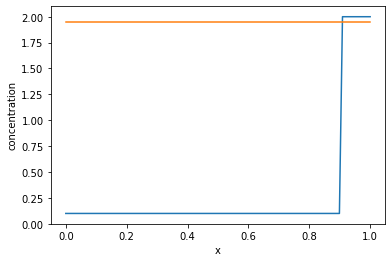

In [13]:
from matplotlib import pyplot as plt
plt.ylim((0., 2.1))
plt.xlabel('x')
plt.ylabel('concentration')
plt.plot(x_grid, U)
plt.plot(x_grid, V)
plt.show()

The blue curve is the initial condition for $U$, stored in Python variable `U`,
and the green curve is the initial condition for $V$ stored in `V`.

### Create Matrices

The matrices that we need to construct are all tridiagonal so they are easy to
construct with 
[`numpy.diagflat`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.diagflat.html).

In [14]:
A_u = numpy.diagflat([-sigma_u for i in range(J-1)], -1) +\
      numpy.diagflat([1.+sigma_u]+[1.+2.*sigma_u for i in range(J-2)]+[1.+sigma_u]) +\
      numpy.diagflat([-sigma_u for i in range(J-1)], 1)
        
B_u = numpy.diagflat([sigma_u for i in range(J-1)], -1) +\
      numpy.diagflat([1.-sigma_u]+[1.-2.*sigma_u for i in range(J-2)]+[1.-sigma_u]) +\
      numpy.diagflat([sigma_u for i in range(J-1)], 1)
        
A_v = numpy.diagflat([-sigma_v for i in range(J-1)], -1) +\
      numpy.diagflat([1.+sigma_v]+[1.+2.*sigma_v for i in range(J-2)]+[1.+sigma_v]) +\
      numpy.diagflat([-sigma_v for i in range(J-1)], 1)
        
B_v = numpy.diagflat([sigma_v for i in range(J-1)], -1) +\
      numpy.diagflat([1.-sigma_v]+[1.-2.*sigma_v for i in range(J-2)]+[1.-sigma_v]) +\
      numpy.diagflat([sigma_v for i in range(J-1)], 1)

To confirm, this is what `A_u` looks like:

In [16]:
print(A_u)

[[ 1.981 -0.981  0.    ...  0.     0.     0.   ]
 [-0.981  2.962 -0.981 ...  0.     0.     0.   ]
 [ 0.    -0.981  2.962 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  2.962 -0.981  0.   ]
 [ 0.     0.     0.    ... -0.981  2.962 -0.981]
 [ 0.     0.     0.    ...  0.    -0.981  1.981]]


### Solve the System Iteratively

To advance our system by one time step, we need to do one matrix-vector multiplication followed by one vector-vector addition on the right hand side.

To facilitate this, we rewrite our reaction term so that it accepts concentration vectors $\mathbf{U}^n$ and $\mathbf{V}^n$ as arguments
and returns vector $\mathbf{f}^n$.

As a reminder, this is our non-vectorial definition of $f$

    f = lambda u, v: v*(k0 + float(u*u)/float(1. + u*u)) - u

In [17]:
f_vec = lambda U, V: numpy.multiply(dt, numpy.subtract(numpy.multiply(V, 
                     numpy.add(k0, numpy.divide(numpy.multiply(U,U), numpy.add(1., numpy.multiply(U,U))))), U))

Let us make certain that this produces the same values as our non-vectorial `f`:

In [20]:
print(f(U[0], V[0]))

0.009961358982745121


In [21]:
print(f(U[-1], V[-1]))

-0.06238322322322325


In [22]:
print(f_vec(U, V))

[ 0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
  0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.01
 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062 -0.062]


Accounting for rounding of the displayed values due to the `set_printoptions` we set above, we
can see that `f` and `f_vec` generate the same values for our initial condition at both ends of our domain.

We will use [`numpy.linalg.solve`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) to solve
our linear system each time step.

While we integrate our system over time we will record both `U` and `V` at each
time step in `U_record` and `V_record` respectively so that we can plot
our numerical solutions over time.

In [23]:
U_record = []
V_record = []

U_record.append(U)
V_record.append(V)

for ti in range(1,N):
    U_new = numpy.linalg.solve(A_u, B_u.dot(U) + f_vec(U,V))
    V_new = numpy.linalg.solve(A_v, B_v.dot(V) - f_vec(U,V))
    
    U = U_new
    V = V_new
    
    U_record.append(U)
    V_record.append(V)

### Plot the Numerical Solution

Let us take a look at the numerical solution we attain after `N` time steps.

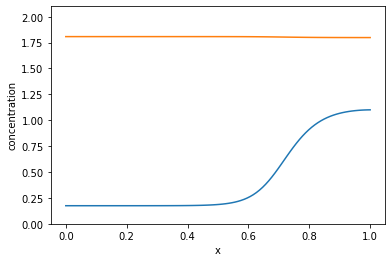

In [26]:
plt.ylim((0., 2.1))
plt.xlabel('x')
plt.ylabel('concentration')
plt.plot(x_grid, U)
plt.plot(x_grid, V)
plt.show()

And here is a [kymograph](http://en.wikipedia.org/wiki/Kymograph) of the values of `U`.
This plot shows concisely the behaviour of `U` over time and we can clear observe the wave-pinning
behaviour described by [Mori *et al.*](http://www.sciencedirect.com/science/article/pii/S0006349508704442).
Furthermore, we observe that this wave pattern is stable for about 50 units of time and we therefore
conclude that this wave pattern is a stable steady state of our system.

<ipython-input-29-1028cb604d99>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  heatmap = ax.pcolor(x_grid, t_grid, U_record, vmin=0., vmax=1.2)


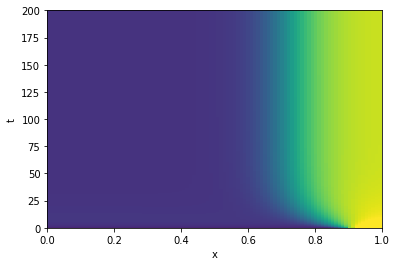

In [29]:
U_record = numpy.array(U_record)
V_record = numpy.array(V_record)

fig, ax = plt.subplots()
plt.xlabel('x');
plt.ylabel('t')
heatmap = ax.pcolor(x_grid, t_grid, U_record, vmin=0., vmax=1.2)